In [93]:
import numpy as np
import pandas as pd
import cv2
import os
import math
import matplotlib.pyplot as plt

from skimage.measure import label, regionprops

In [34]:
## Paths to access Control (c) and PD (pd) segmented images
path = '/Users/HOMEDRIVE/data'
c_path = 'c images'
pd_path = 'pd images'

In [35]:
## Files listed
c_files = os.listdir(os.path.join(path, c_path))
pd_files = os.listdir(os.path.join(path, pd_path))

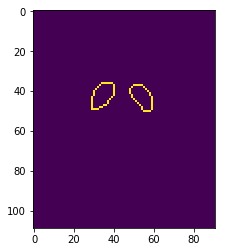

In [231]:
img = cv2.imread(os.path.join(path, c_path, c_files[1]), 0)
plt.imshow(img)

In [171]:
## Computes tan inverse between 0 to 2pi
def atan0to2pi (xx, yy):
    z = yy/xx
    if (xx >= 0) and (yy >= 0):
        theta = math.atan(z)
    elif (xx < 0):
        theta = math.atan(z) + math.pi
    elif (xx >= 0) and (yy < 0):
        theta = math.atan(z) + (2 * math.pi)
    return theta

In [242]:
## Computes 8 sampled points such that striatum boundary is approximately divided into 8 segments 
def ComputeSuper8 (boundPel, theta):
    sampled_8pts = np.zeros((8,2))
    angles = [0, 45, 90, 135, 180, 255, 270, 315]
    
    for i in range(len(angles)):
        ## finds the point closest to required angle 
        theta_ang_diff = [th - ((angles[i]*math.pi)/180) for th in theta]
        diff_ang = [abs(e_val) for e_val in theta_ang_diff]
        idx = diff_ang.index(min(diff_ang))
        if (i > 0):
            if (sampled_8pts[i-1].all() == sampled_8pts[i].all()):
                sorted_diffang = sorted(diff_ang)
                idx = diff_ang.index(sorted_diffang[1])  
        sampled_8pts[i][0] = boundPel[idx][0]
        sampled_8pts[i][1] = boundPel[idx][1] 
    
    return sampled_8pts

In [236]:
## Gives 8 sampled points on each left and right striatum
def LR_landmarks (center_L, center_R, boundPel_L, boundPel_R):
    theta_L = []
    for i in range(len(boundPel_L)):
        centroid_x = center_L[0]
        centroid_y = center_L[1]
        borderPel_x = boundPel_L[i][0]
        borderPel_y = boundPel_L[i][1]
        xx = borderPel_x - centroid_x
        yy = borderPel_y - centroid_y
        theta = atan0to2pi(xx, yy)
        theta_L.append(theta)

    
    theta_R = []
    for i in range(len(boundPel_R)):
        centroid_x = center_R[0]
        centroid_y = center_R[1]
        borderPel_x = boundPel_R[i][0]
        borderPel_y = boundPel_R[i][1]
        xx = borderPel_x - centroid_x
        yy = borderPel_y - centroid_y
        theta = atan0to2pi(xx, yy)
        theta_R.append(theta)
    
    sampled_8pts_L = ComputeSuper8(boundPel_L, theta_L)
    sampled_8pts_R = ComputeSuper8(boundPel_R, theta_R)
    
    return sampled_8pts_L, sampled_8pts_R
    

In [243]:
## Computes radial (rad) features
def RadFeat (center, sampled_pts):
    centroid_x = center[0]
    centroid_y = center[1]
    rad_dist = []
    for i in sampled_pts:
        borderPel_x = i[0]
        borderPel_y = i[1]
        dist = math.sqrt(((borderPel_x - centroid_x)**2) + ((borderPel_y - centroid_y)**2))
        rad_dist.append(dist)
    return rad_dist

In [244]:
## Computes gradient (grad) features
def GradFeat (sampled_pts):
    sampled_pts = list(sampled_pts)
    sampled_pts.append(sampled_pts[0])
    grad_val = []
    for i in range(len(sampled_pts)-1):
        borderPel_x1 = sampled_pts[i][0]
        borderPel_y1 = sampled_pts[i][1]
        borderPel_x2 = sampled_pts[i+1][0]
        borderPel_y2 = sampled_pts[i+1][1]
        xx = borderPel_x2 - borderPel_x1
        yy = borderPel_y2 - borderPel_y1
        grad = atan0to2pi (xx, yy)
        grad_val.append(grad)
    return grad_val

In [245]:

c_imgs = []
c_rad_feat_L = []
c_rad_feat_R = []
c_grad_feat_L = []
c_grad_feat_R = []
for i in c_files:
    if ('.png' in i)==True:
        img = cv2.imread(os.path.join(path, c_path, i), 0)
        img = img/255
        img1 = label(img) #labels each region in the image 
        props = regionprops(img1) #gives region properties for labeled image
        
        center_L = props[0].centroid
        center_R = props[1].centroid
        
        boundPel_L = props[0].coords
        boundPel_R = props[1].coords
        
        sampled_8pts_L, sampled_8pts_R = LR_landmarks (center_L, center_R, boundPel_L, boundPel_R)
        
        rad_feats_L = RadFeat(center_L, sampled_8pts_L)
        rad_feats_R = RadFeat(center_R, sampled_8pts_R)
        
        grad_feats_L = GradFeat(sampled_8pts_L)
        grad_feats_R = GradFeat(sampled_8pts_R)
        
        c_imgs.append(img)
        c_rad_feat_L.append(rad_feats_L)
        c_rad_feat_R.append(rad_feats_R)
        c_grad_feat_L.append(grad_feats_L)
        c_grad_feat_R.append(grad_feats_R)
        
c_imgs = np.array(c_imgs)


pd_imgs = []
pd_rad_feat_L = []
pd_rad_feat_R = []
pd_grad_feat_L = []
pd_grad_feat_R = []
for i in pd_files:
    if ('.png' in i)==True:
        img = cv2.imread(os.path.join(path, pd_path, i), 0)
        img = img/255
        img1 = label(img) #labels each region in the image
        props = regionprops(img1) #gives region properties for labeled image
        
        center_L = props[0].centroid
        center_R = props[1].centroid
        
        boundPel_L = props[0].coords
        boundPel_R = props[1].coords
        
        sampled_8pts_L, sampled_8pts_R = LR_landmarks (center_L, center_R, boundPel_L, boundPel_R)
        
        rad_feats_L = RadFeat(center_L, sampled_8pts_L)
        rad_feats_R = RadFeat(center_R, sampled_8pts_R)
        
        grad_feats_L = GradFeat(sampled_8pts_L)
        grad_feats_R = GradFeat(sampled_8pts_R)
        
        pd_imgs.append(img)
        pd_rad_feat_L.append(rad_feats_L)
        pd_rad_feat_R.append(rad_feats_R)
        pd_grad_feat_L.append(grad_feats_L)
        pd_grad_feat_R.append(grad_feats_R)
        
pd_imgs = np.array(pd_imgs)


/Users/noopurbhalchandra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
/Users/noopurbhalchandra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


{'whiskers': [<matplotlib.lines.Line2D at 0x1c27dc7198>,
 'caps': [<matplotlib.lines.Line2D at 0x1c27dc7a58>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c27dc7048>,
 'medians': [<matplotlib.lines.Line2D at 0x1c27db42e8>,
 'fliers': [<matplotlib.lines.Line2D at 0x1c27db4710>,
 'means': []}

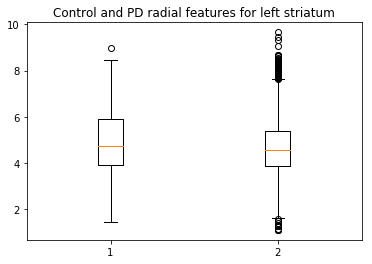

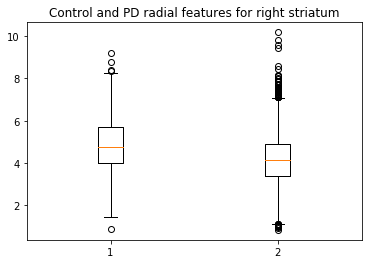

In [257]:
fig1, ax1 = plt.subplots()
rad_L = [c_rad_feat_L[:], pd_rad_feat_L[:]]
ax1.set_title('Control and PD radial features for left striatum')
ax1.boxplot(rad_L)

fig2, ax2 = plt.subplots()
rad_R = [c_rad_feat_R[:], pd_rad_feat_R[:]]
ax2.set_title('Control and PD radial features for right striatum')
ax2.boxplot(rad_R)